# Assignment 3 - Autoregressive Language Modeling with Transformers

In [1]:
%pip install torch==2.4.1 datasets==3.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

from datasets import load_dataset

# Data

In [3]:
import torch
from datasets import load_dataset

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, block_size=256):
        # Load dataset
        ds = load_dataset("Pablinho/movies-dataset")
        data = ds['train'].to_pandas()

        # Convert to pandas and create string format
        text_data = ""
        for _, row in data.iterrows():
            text_data += f"{row['Title']}: {row['Overview']}\n"

        # Create character mappings
        chars = sorted(list(set(text_data)))
        self.string_to_int = {ch:i for i,ch in enumerate(chars)}
        self.int_to_string = {i:ch for i,ch in enumerate(chars)}

        # Encode text to integers
        encoded_data = [self.string_to_int[c] for c in text_data]

        # Convert to tensor
        self.data = torch.tensor(encoded_data, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # all but last
        y = chunk[1:]   # all but first
        return x, y

    def decode(self, ids):
        return ''.join([self.int_to_string[i.item()] for i in ids])

## Task a)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

9000plus.csv:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9837 [00:00<?, ? examples/s]

1. Dataset Content Analysis:
Total characters in the dataset: 3002101
Unique characters (vocabulary size): 169
Example unique characters: ['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'"]

Most common characters:
' ': 499859
'e': 290022
't': 195126
'a': 193505
'o': 171696
'i': 171218
'n': 170269
'r': 157127
's': 156990
'h': 125681

Least common characters:
'`': 1
'«': 1
'»': 1
'	': 1
'_': 1
'‑': 1
'£': 1
'″': 1
'Å': 1
'ª': 1


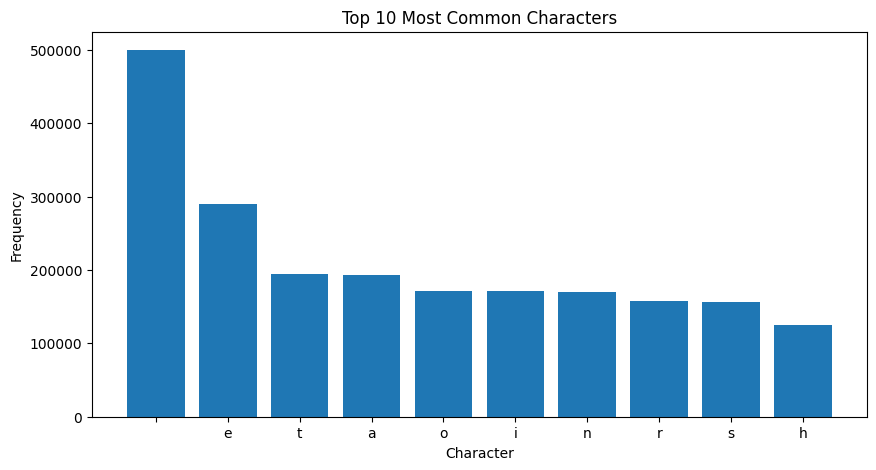


2. Sample Batch Analysis:
Shape of input (x): torch.Size([1000, 256])
Shape of target (y): torch.Size([1000, 256])

Decoded Input (x[0]): nt and is speeding along the Apocalypse by bloodying rivers, egging on plagues and following scripture word for word.
Blackway: A young woman newly returned to her hometown becomes the subject of harassment by a man named Blackway, an ex-cop turned violent
Decoded Target (y[0]): t and is speeding along the Apocalypse by bloodying rivers, egging on plagues and following scripture word for word.
Blackway: A young woman newly returned to her hometown becomes the subject of harassment by a man named Blackway, an ex-cop turned violent 

Decoded Input (x[1]): soon find out that it's overrun by bike gangs and vampires. A couple of teenage friends take it upon themselves to hunt down the vampires that they suspect of a few mysterious murders and restore peace and calm to their town.
Misha and the Wolves: A woman’
Decoded Target (y[1]): oon find out that it'

In [4]:
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Instantiate the dataset
block_size = 256  # A meaningful context length for modeling
batch_size = 1000  # A large batch size to explore the data at scale
dataset = MovieDataset(block_size=block_size)

# PART 1: Analyze dataset structure (What does the dataset contain?)
print("1. Dataset Content Analysis:")
print(f"Total characters in the dataset: {len(dataset.data)}")
print(f"Unique characters (vocabulary size): {len(dataset.string_to_int)}")
print(f"Example unique characters: {list(dataset.string_to_int.keys())[:10]}")

# Count the frequency of each character
char_counts = collections.Counter(dataset.data.tolist())
most_common_chars = char_counts.most_common(10)
least_common_chars = char_counts.most_common()[-10:]

print("\nMost common characters:")
for char, count in most_common_chars:
    print(f"'{dataset.int_to_string[char]}': {count}")

print("\nLeast common characters:")
for char, count in least_common_chars:
    print(f"'{dataset.int_to_string[char]}': {count}")

# Plot character frequency distribution
plt.figure(figsize=(10, 5))
plt.bar([dataset.int_to_string[char] for char, _ in most_common_chars],
        [count for _, count in most_common_chars])
plt.title("Top 10 Most Common Characters")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()

# PART 2: Fetch a sample batch and analyze (What does the dataloader return?)
print("\n2. Sample Batch Analysis:")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Fetch one batch
for batch in dataloader:
    x, y = batch
    print(f"Shape of input (x): {x.shape}")  # (batch_size, block_size)
    print(f"Shape of target (y): {y.shape}")  # (batch_size, block_size)

    # Decode and display a subset of sequences for interpretability
    for i in range(3):  # Show first 3 examples for clarity
        print(f"\nDecoded Input (x[{i}]):", dataset.decode(x[i]))
        print(f"Decoded Target (y[{i}]):", dataset.decode(y[i]))
    break

# PART 3: Analyze Block Size Impact
print("\n3. Block Size Impact Analysis:")
print(f"Block size controls the sequence length for input and target.")
print(f"Current block size: {block_size}")
print(f"Each input and target pair is {block_size} characters long.")

# Model

In [5]:
@dataclass
class GPTConfig:
    vocab_size: int # Number of unique tokens in the vocabulary
    block_size: int = 256 # Sequence length
    n_block: int = 6 # Number of blocks in the transformer
    n_head: int = 6 # Number of attention heads
    n_embd: int = 384 # Embedding dimensionality
    dropout: float = 0.2 # Dropout rate
    bias: bool = True # If True, we add a bias to the LayerNorm and Linear layers.

In [6]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, f"Embedding dimension {config.n_embd} must be divisible by number of heads {config.n_head}"

        self.n_head = config.n_head # Number of attention heads
        self.n_embd = config.n_embd # Embedding dimensionality
        self.dropout = config.dropout # Dropout rate

        # Maps embedding into Q, K, V. We'll use one layer to generate these matrices for all heads at once.
        self.qkv_map = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # After performing attention for each head individually, we concat the results
        # and feed them through this linear layer.
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.final_dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        B, T, C = x.shape # Batch size, sequence length, n_embd
        d_k = C // self.n_head # Dimension of the query, key, and value vectors (within a head)

        # TODO: Implement Causal Self Attention
        # Hint: The output of the qkv_map is a tensor of shape (B, T, 3*C).
        # We need to split this tensor into Q, K, and V tensors of shape (B, T, C) each.
        # Afterwards, reshape and transpose them to the correct shape (see assert statements),
        # such that we have (smaller) Q, K, and V matrices for each head.
        #DONE: Generate Q, K, V from input x
        # The input x is passed through the qkv_map linear layer to produce Q, K, and V matrices.
        # These matrices are concatenated into a single tensor of shape (B, T, 3*C).
        qkv = self.qkv_map(x)  # Shape: (B, T, 3*C)
        Q, K, V = torch.split(qkv, C, dim=2)  # Each of shape: (B, T, C)
        # DONE: Reshape and transpose for multi-head attention
        # The Q, K, and V matrices are reshaped to separate the multiple attention heads.
        # They are transposed to bring the attention head dimension to the second position.
        Q = Q.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        K = K.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        V = V.view(B, T, self.n_head, d_k).transpose(1, 2)  # Shape: (B, n_head, T, d_k)
        for M in [Q, K, V]:
            assert M.shape == (B, self.n_head, T, d_k), f"Expected shape (B, self.n_head, T, d_k), but got {M.shape}"

        # TODO: Compute the attention weights and aggregated values as specified in the assignment sheet.
        # Hint: Broadcasted matrix multiplication can be implemented using the @ operator.
        # Hint: `torch.tril` may help you with masking the attention scores.
        # DONE: Compute scaled dot-product attention with causal masking
        # Attention scores are computed using the dot product of Q and K, scaled by the square root of d_k.
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # Causal mask ensures that tokens can only attend to themselves and previous tokens.
        causal_mask = torch.tril(torch.ones(T, T, device=x.device))  # Shape: (T, T)
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))

        # DONE: Softmax to get attention weights
        # The attention scores are passed through a softmax to normalize them.
        attn_weights = torch.softmax(attn_scores, dim=-1)  # Shape: (B, n_head, T, T)

        # DONE: Weighted sum of values
        # The attention weights are used to compute a weighted sum of the V matrix.
        aggregated_vals = torch.matmul(attn_weights, V)  # Shape: (B, n_head, T, d_k)
        assert aggregated_vals.shape == (B, self.n_head, T, d_k), f"Expected aggregated_vals shape (B, self.n_head, T, d_k), but got {aggregated_vals.shape}"

        # Combine all head outputs into the last dimension
        out = aggregated_vals.transpose(1, 2).reshape(B, T, C)
        out = self.proj(out) # This combines the outputs of all heads
        out = self.final_dropout(out) # This is the final dropout layer

        return out

You can test your implementation of the `CausalSelfAttention` class by running the following code:

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = GPTConfig(vocab_size=10, block_size=8, n_block=6, n_head=6, n_embd=12, dropout=0.0, bias=True)

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

x = torch.randn(2, 8, 12).to(device)
attention = CausalSelfAttention(config).to(device)
att_out = attention(x)

# Read expected output from file
att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device, weights_only=True)

assert torch.allclose(att_out, att_out_expected, atol=1e-7), "Outputs do not match!"
print("Test passed successfully!")

Test passed successfully!


In [9]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Implement the MLP
        # It should consist of a linear layer, a GELU activation function, and a final linear layer.
        # After the final linear layer, apply dropout with dropout rate config.dropout.
        # The first linear layer should map from config.n_embd to 4 * config.n_embd.
        # The second linear layer should map from 4 * config.n_embd back to config.n_embd.
        # The linear layers should have a bias term if config.bias is True, and no bias term otherwise.
         # First Linear Layer
        # Expands the input dimensionality from `config.n_embd` to `4 * config.n_embd`.
        # The bias term is controlled by `config.bias`.
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)

        # GELU Activation
        # Applies the GELU (Gaussian Error Linear Unit) non-linearity.
        self.gelu = nn.GELU()

        # Second Linear Layer
        # Projects the expanded dimensionality `4 * config.n_embd` back to `config.n_embd`.
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)

        # Dropout
        # Applies dropout after the final linear layer to prevent overfitting.
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        # TODO: Implement the forward pass of the MLP
        # Step 1: Apply the first linear transformation.
        # This expands the input size from `n_embd` to `4 * n_embd`.
        x = self.fc1(x)

        # Step 2: Apply the GELU activation function.
        # Introduces non-linearity to the MLP block.
        x = self.gelu(x)

        # Step 3: Apply the second linear transformation.
        # Projects the expanded dimensionality back to the original size (`n_embd`).
        x = self.fc2(x)

        # Step 4: Apply dropout.
        # Prevents overfitting by randomly zeroing some elements of the output.
        x = self.dropout(x)

        # Step 5: Return the final output.
        return x

In [10]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attention = CausalSelfAttention(config)
        self.layernorm_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.mlp(self.layernorm_2(x))
        return x

In [11]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            embed_token = nn.Embedding(config.vocab_size, config.n_embd),
            embed_position = nn.Embedding(config.block_size, config.n_embd),
            dropout = nn.Dropout(config.dropout),
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_block)]),
            layernorm = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # We use the same weights for the token embeddings and the final linear layer.
        # This is a form of "weight tying", see https://paperswithcode.com/method/weight-tying
        self.transformer.embed_token.weight = self.head.weight

        # Initialize all linear layers using our custom init function
        self.apply(self._init_params)

        # report number of parameters
        print(f"Number of parameters in GPT: {self.get_num_params()/1e6:.2f}M")


    def _init_params(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())


    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.shape
        assert t <= self.config.block_size, f"Cannot process sequence of length {t}, block size is only {self.config.block_size}"
        position_idxs = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # DONE: Implement the forward pass of the GPT model
        # Embed the tokens and positions using the embedding layers self.transformer.embed_token and self.transformer.embed_position.
        # Add the token embeddings and position embeddings together and pass the result through the dropout layer.
        # Pass the result through all the transformer blocks.
        # Apply layer normalization and finally obtain the logits by project the result to
        # the vocabulary space using the head layer.

        # Step 1: Token and positional embeddings
        token_embeddings = self.transformer.embed_token(idx)  # Shape: (batch_size, seq_length, n_embd)

        position_embeddings = self.transformer.embed_position(position_idxs)  # Shape: (seq_length, n_embd)

        # Combine token and positional embeddings, then apply dropout
        x = self.transformer.dropout(token_embeddings + position_embeddings)

        # Step 2: Pass through all transformer blocks
        for block in self.transformer.blocks:
            x = block(x)  # Each block applies attention, MLP, and residual connections

        # Step 3: Apply final layer normalization
        x = self.transformer.layernorm(x)  # Shape: (batch_size, seq_length, n_embd)

        # Step 4: Project to vocabulary size using the head layer
        logits = self.head(x)  # Shape: (batch_size, seq_length, vocab_size)

        if targets is not None:
            # We calculate the loss if targets are provided (i.e., during training)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), ignore_index=-1)
        else:
            loss = None

        return logits, loss


    def get_optimizer(self, weight_decay, learning_rate, betas, device):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # We will decay all parameters that are 2D or higher dimensional.
        # This includes all weight matrices and embeddings.
        decay_params = [p for n, p in param_dict.items() if len(p.shape) >= 2]
        # We will not decay biases and layernorm parameters (which are 1D).
        nodecay_params = [p for n, p in param_dict.items() if len(p.shape) < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        fused = (device == 'cuda')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, fused=fused)

        return optimizer


    @torch.no_grad()
    def sample(self, idx, max_new_tokens, temperature=1.0):
        for _ in range(max_new_tokens):
          # Crop the input sequence if it exceeds the block size
          idx_input = idx if idx.shape[1] <= self.config.block_size else idx[:, -self.config.block_size:]

          # Forward pass: Get logits from the model
          logits, _ = self.forward(idx_input)

          # Extract logits for the last token in the sequence
          logits = logits[:, -1, :]

          # Apply temperature scaling
          logits = logits / temperature

          # Convert logits to probabilities
          probs = F.softmax(logits, dim=-1)

          # Sample next token from the probability distribution
          next_token = torch.multinomial(probs, num_samples=1)

          # Append the sampled token to the sequence
          idx = torch.cat((idx, next_token), dim=1)

        return idx

# Training

In [12]:
@torch.no_grad()
def estimate_train_val_loss(model, train_loader, val_loader, val_iters, device):
    model.eval()
    losses = {}
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        for i, (X, Y) in enumerate(loader):
            if i >= val_iters:
                break
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            total_loss += loss.item()
        losses[split] = total_loss / val_iters
    model.train()
    return losses

In [13]:
# Set seeds for reproducibility
torch.manual_seed(1337)

block_size = 128
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

Number of parameters in GPT: 0.83M
iter 0: loss 5.0872
step 0: train loss 4.5851, val loss 4.5848
iter 10: loss 5.9965
iter 20: loss 2.9859
iter 30: loss 2.7765
iter 40: loss 2.6648
iter 50: loss 2.6022
iter 60: loss 2.5829
iter 70: loss 2.5539
iter 80: loss 2.5404
iter 90: loss 2.5271
iter 100: loss 2.4973
iter 110: loss 2.5112
iter 120: loss 2.5113
iter 130: loss 2.5027
iter 140: loss 2.4631
iter 150: loss 2.4540
iter 160: loss 2.4404
iter 170: loss 2.4154
iter 180: loss 2.4091
iter 190: loss 2.3911
iter 200: loss 2.3841
iter 210: loss 2.3519
iter 220: loss 2.3207
iter 230: loss 2.2970
iter 240: loss 2.2961
iter 250: loss 2.2717
iter 260: loss 2.2217
iter 270: loss 2.2035
iter 280: loss 2.2017
iter 290: loss 2.1740
iter 300: loss 2.1588
iter 310: loss 2.1459
iter 320: loss 2.1219
iter 330: loss 2.0811
iter 340: loss 2.0946
iter 350: loss 2.0708
iter 360: loss 2.0317
iter 370: loss 2.0471
iter 380: loss 2.0000
iter 390: loss 2.0241
iter 400: loss 2.0103
iter 410: loss 1.9751
iter 420:

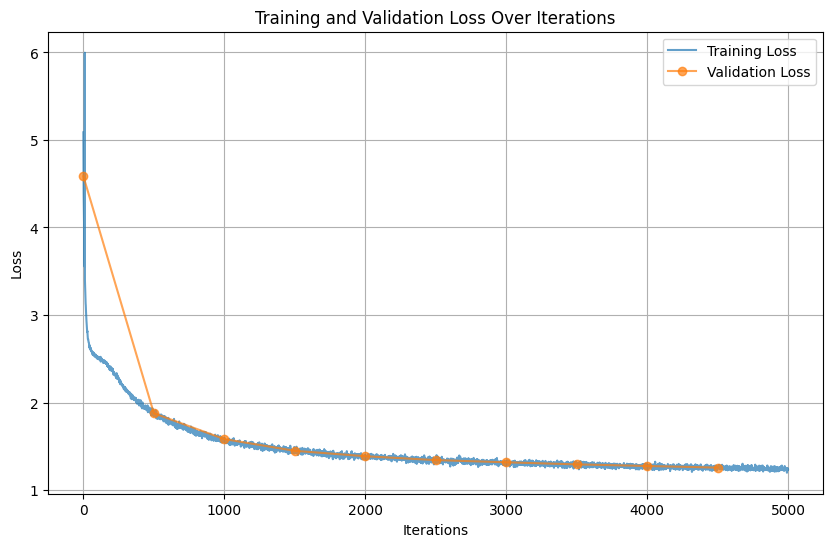

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rate = 1e-3 # Larger networks typically require a learning rate that is smaller than this
max_iters = 5_000 # Number of iterations to train for
weight_decay = 1e-1 # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clip = 1.0 # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = False  # Compile the model for faster execution (set to false to avoid errors)

# Model config
vocab_size = len(data.string_to_int) # DONE TODO: Use the dataset `data` to determine the vocabulary size
config = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=4,
    n_head=4,
    n_embd=128,
    dropout=0.0,
    bias=False
) # This is a relatively small model

model = GPT(config).to(device)

if compile_model:
    print("Compiling the model...")
    model = torch.compile(model) # Needs PyTorch >= 2.0
    print("Done compiling")

# Initialize optimizer
optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

# Training loop
iter_num = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []

for _ in range(max_iters):

    for X, Y in train_loader:
        # Get batch and move to device
        X, Y = X.to(device), Y.to(device)

        # Forward pass
        logits, loss = model(X, targets=Y)
        train_losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip != 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # Logging
        if iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss.item():.4f}")

        # Evaluation
        if iter_num % val_interval == 0:
            losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            val_losses.append(losses['val'])

            # Save best model
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                if iter_num > 0:
                    print(f"Saving checkpoint to {out_dir}")
                    model_to_save = model._orig_mod if compile_model else model
                    torch.save({
                        'model': model_to_save.state_dict(),
                        'model_args': config,
                    }, checkpoint_path)

        iter_num += 1
        if iter_num >= max_iters:
            break

    if iter_num >= max_iters:
        break

# Plot training and validation losses (task f)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(
    [i * val_interval for i in range(len(val_losses))],
    val_losses,
    label='Validation Loss',
    marker='o',
    alpha=0.7
)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, 'loss_plot_1.png'))
plt.show()

# Sample from the model

In [15]:
num_samples = 5  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample
temperature = 0.8  # TODO: Use different temperature values and qualitatively report on the results
temperature_values = [1.5, 1.0, 0.8, 0.5, 0.1, 0.0001]

# Set seed for reproducibility
seed = 345
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Load the model
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['model_args']
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# Generate samples
for temp in temperature_values:
    print(f"GENERATING SAMPLES WITH TEMPERATURE: {temp}")
    print('-'*20)
    with torch.no_grad():
        for k in range(num_samples):
            start_prompt = "\n"  # Start prompt
            prompt_ids = encode(start_prompt)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]

            y = model.sample(x, max_new_tokens, temperature=temp)
            print(decode(y[0]))
            print('-'*20)

<ipython-input-15-769fb87ad244>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Number of parameters in GPT: 0.83M
GENERATING SAMPLES WITH TEMPERATURE: 1.5
--------------------

Jessmaizer Rama: Wheno,Z (who substrusten), nort_T Aot Shaniti Lovedhot Darve con Qiens1.. Autissolrique?)uartes (Gry' 68JFJG: thes) shie’ the Pavi Nâtocon RipPy Wam when Digim-EX Samandr. Their main kids' been: left lead Hamzothti. Culne:
Suppokekid: Japanese worville.
Demivative, Margay Highway's LASIjál: Ni, brutal, next abilount. Once there of Omain's pirror, Roy, Jolin evers vamborie, the ambs dyma—secment-award's life, Y.K.’’Spenfulfishermes structioned that in low the Ma'splym, whils, obl
--------------------

HoweQ!.: Twanted bloach McC. They'll doll fit stop to verquizioner with cuf, this only submasmen malfuries herself to tsai
Danetime EggÁBs: Throughth 17th OzT!) anothfaght Taina haim outfnair,ina years last inspatched Future's éusing scynics he made DamnG Tamurt. 12 is dropping with Croje Hot, Mr.eferveluringly, Blax, Nco, lonean kill, Peope, has a Viji-frecting 1AZ is baby: C

## Task h)

In [16]:
import itertools
import json

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)

compile_model = False

# Output directory for results
out_dir = 'MovieGPT'
os.makedirs(out_dir, exist_ok=True)

def create_simple_checkpoint_path(experiment_id):
    filename = f"checkpoint_{experiment_id}.pt"
    return os.path.join(out_dir, filename)

# Function to run an experiment
def run_experiment(hyperparams, model_params, experiment_id):
    # Unpack parameters
    learning_rate = hyperparams['new_learning_rate']
    batch_size = hyperparams['new_batch_size']
    weight_decay = hyperparams['weight_decay']
    grad_clip = hyperparams['new_grad_clip']
    dropout = hyperparams['new_dropout']

    block_size = model_params['new_block_size']
    n_block = model_params['n_block']
    n_head = model_params['n_head']
    n_embd = model_params['n_embd']

    # Initialize dataset
    data = MovieDataset(block_size)
    train_len = int(len(data) * 0.8)
    val_len = len(data) - train_len
    train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    # Initialize model
    vocab_size = len(data.string_to_int)
    config = GPTConfig(
        block_size=block_size,
        vocab_size=vocab_size,
        n_block=n_block,
        n_head=n_head,
        n_embd=n_embd,
        dropout=dropout,
        bias=True
    )
    model = GPT(config).to(device)
    if compile_model:
      print("Compiling the model...")
      model = torch.compile(model) # Needs PyTorch >= 2.0
      print("Done compiling")
    optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

    # Training loop
    train_losses = []
    val_losses = []
    max_iters = 5_000  # Use smaller max_iters for quick experimentation

    # Generate a simplified checkpoint path for this experiment
    checkpoint_path = create_simple_checkpoint_path(experiment_id)

    iter_num = 0
    best_val_loss = float('inf')

    for _ in range(max_iters):
      for X, Y in train_loader:
          X, Y = X.to(device), Y.to(device)
          logits, loss = model(X, targets=Y)
          train_losses.append(loss.item())
          optimizer.zero_grad(set_to_none=True)
          loss.backward()
          if grad_clip != 0.0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
          optimizer.step()

          # Evaluate at intervals
          if iter_num % 500 == 0:
              val_loss = estimate_train_val_loss(model, train_loader, val_loader, 10, device)
              print(f"step {iter_num}: train loss {val_loss['train']:.4f}, val loss {val_loss['val']:.4f}")
              val_losses.append(val_loss['val'])

              # Save best model checkpoint
              if val_loss['val'] < best_val_loss:
                  best_val_loss = val_loss['val']
                  print(f"Saving checkpoint for experiment {experiment_id} to {checkpoint_path}")
                  print(f"Parameters: Hyperparameters: {hyperparams}, Model Params: {model_params}")
                  model_to_save = model._orig_mod if compile_model else model
                  torch.save({
                      'model': model_to_save.state_dict(),
                      'model_args': config,
                  }, checkpoint_path)

          iter_num += 1
          if iter_num >= max_iters:
              break

      if iter_num >= max_iters:
          break

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'checkpoint_path': checkpoint_path
    }

### The best model has the hyperparameters:
"hyperparams": {
            "new_learning_rate": 0.001,
            "new_batch_size": 128,
            "weight_decay": 0.01,
            "new_grad_clip": 1.0,
            "new_dropout": 0.0
        }

In [ ]:
hyperparameter_grid = {
    'new_learning_rate': [1e-3],
    'new_batch_size': [128],
    'weight_decay': [1e-2],
    'new_grad_clip': [1.0],
    'new_dropout': [0.0]
}

# Parameter grids for model size tuning
model_size_grid = {
    'n_block': [8],
    'n_head': [8],
    'n_embd': [256],
    'new_block_size': [256]
}

# Experiment with hyperparameters
hyperparam_combinations = list(itertools.product(*hyperparameter_grid.values()))
model_combinations = list(itertools.product(*model_size_grid.values()))

# Logging results
results_best_model = []
experiment_id = "best_larger_model"
for hyperparam_values in hyperparam_combinations:
    for model_param_values in model_combinations:
        hyperparams = dict(zip(hyperparameter_grid.keys(), hyperparam_values))
        model_params = dict(zip(model_size_grid.keys(), model_param_values))

        print(f"Running experiment {experiment_id} with hyperparams: {hyperparams}, model_params: {model_params}")
        result = run_experiment(hyperparams, model_params, experiment_id)
        results_best_model.append({
            'experiment_id': experiment_id,
            'hyperparams': hyperparams,
            'model_params': model_params,
            'result': result
        })

# Save all results
with open(os.path.join(out_dir, 'best_model_results.json'), 'w') as f:
    json.dump(results_best_model, f, indent=4)

Running experiment best_larger_model with hyperparams: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, model_params: {'n_block': 8, 'n_head': 8, 'n_embd': 256, 'new_block_size': 256}
Number of parameters in GPT: 6.43M
step 0: train loss 4.4151, val loss 4.4154
Saving checkpoint for experiment best_larger_model to MovieGPT/checkpoint_best_larger_model.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, Model Params: {'n_block': 8, 'n_head': 8, 'n_embd': 256, 'new_block_size': 256}
step 500: train loss 1.9614, val loss 1.9636
Saving checkpoint for experiment best_larger_model to MovieGPT/checkpoint_best_larger_model.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, Model Params: {'n_block': 8, 'n_head': 8, 'n_embd': 256, 'new_b

In [ ]:
# Load the best validation loss from the best model
best_model_info = min(results_best_model, key=lambda x: x['result']['best_val_loss'])

print(f"Best Validation Loss: {best_model_info['result']['best_val_loss']}")
print(f"Best Model Hyperparameters: {best_model_info['hyperparams']}")
print(f"Best Model Parameters: {best_model_info['model_params']}")

Best Validation Loss: 0.5877177953720093
Best Model Hyperparameters: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}
Best Model Parameters: {'n_block': 8, 'n_head': 8, 'n_embd': 256, 'new_block_size': 256}


Loss plot for best model saved to MovieGPT/best_model_losses.png


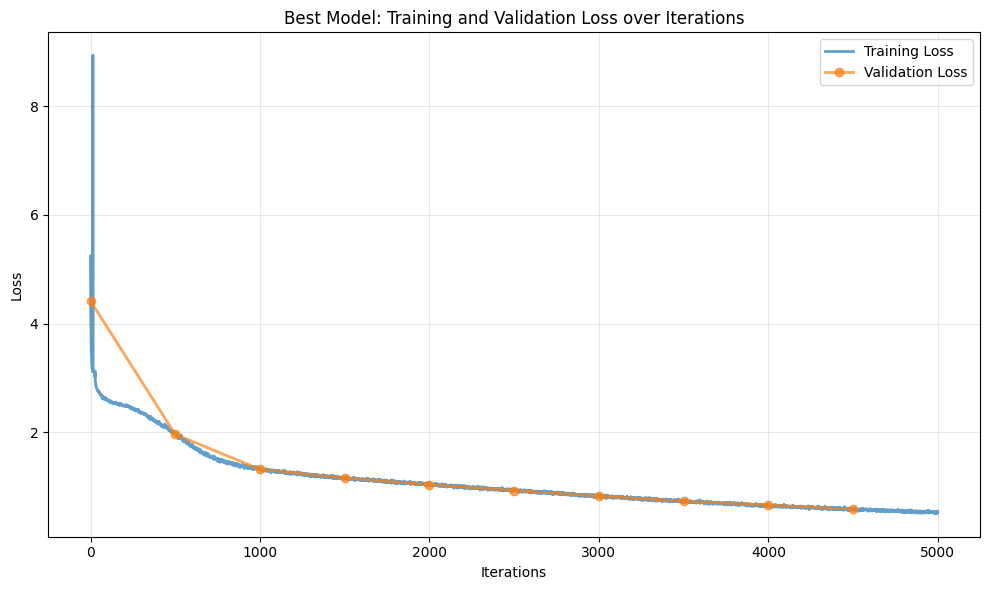

In [ ]:
import matplotlib.pyplot as plt

train_losses = best_model_info['result']['train_losses']
val_losses = best_model_info['result']['val_losses']

val_iters = list(range(0, len(train_losses), len(train_losses) // len(val_losses)))

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", alpha=0.7, linewidth=2)
plt.plot(val_iters, val_losses, label="Validation Loss", alpha=0.7, linewidth=2, marker='o')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Best Model: Training and Validation Loss over Iterations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(out_dir, 'best_model_losses.png')
plt.savefig(plot_path)
print(f"Loss plot for best model saved to {plot_path}")

plt.show()

In [ ]:
num_samples = 2  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample
temperature = 0.5

# Set seed for reproducibility
seed = 345
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Load the model
checkpoint_path = os.path.join(out_dir, 'checkpoint_best_larger_model.pt')
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['model_args']
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# Generate samples
print('-'*20)
with torch.no_grad():
    for k in range(num_samples):
        start_prompt = "\n"  # Start prompt
        prompt_ids = encode(start_prompt)
        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]

        y = model.sample(x, max_new_tokens, temperature=temperature)
        print(decode(y[0]))
        print('-'*20)

<ipython-input-25-b8e24ea350e9>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Number of parameters in GPT: 6.43M
--------------------

Jesus Christmas: The official story of the Legendary Last Valley of the Destruction on the American president and is released on the Navy warden who has gone refuge with the Lawre Bank and the world is about to believe in an undetectable book.
The Last Dark: A successful, five-week penguins but first sight will have to go up in over as different sides every day.
The Stolen Prince: A young farm boy migrates his groom and leads a single mom shooting in a modern student and stepbring boxer with a p
--------------------

The World of Metropolis: Mnike is a brilliant drug pug, a woman seeks redemption and let her for lost her beloved powers. She stars to worried love for someone she thinks she is about to believe. This film was exposed to an act of defeating the allied monses including the painting ring of triple makes a stand as he his cousin fantasies and inspires him to his house that he is the only daunting reality would she can b

### Hyperparameter search that brought us to the best model above

In [17]:
hyperparameter_grid = {
    'new_learning_rate': [1e-2, 1e-3],
    'new_batch_size': [128],
    'weight_decay': [1e-2, 1e-1],
    'new_grad_clip': [1.0, 0.5],
    'new_dropout': [0.0]
}

# Parameter grids for model size tuning
model_size_grid = {
    'n_block': [4],
    'n_head': [4],
    'n_embd': [128],
    'new_block_size': [128]
}

# Experiment with hyperparameters
hyperparam_combinations = list(itertools.product(*hyperparameter_grid.values()))
model_combinations = list(itertools.product(*model_size_grid.values()))

# Logging results
results = []
experiment_id = 0
for hyperparam_values in hyperparam_combinations:
    for model_param_values in model_combinations:
        hyperparams = dict(zip(hyperparameter_grid.keys(), hyperparam_values))
        model_params = dict(zip(model_size_grid.keys(), model_param_values))

        print(f"Running experiment {experiment_id} with hyperparams: {hyperparams}, model_params: {model_params}")
        result = run_experiment(hyperparams, model_params, experiment_id)
        results.append({
            'experiment_id': experiment_id,
            'hyperparams': hyperparams,
            'model_params': model_params,
            'result': result
        })

        # Load the best validation loss from the model
        model_info = min(results, key=lambda x: x['result']['best_val_loss'])

        print(f"Best Validation Loss: {model_info['result']['best_val_loss']}")
        print(f"Best Model Hyperparameters: {model_info['hyperparams']}")
        print(f"Best Model Parameters: {model_info['model_params']}")

        experiment_id += 1

# Save all results
with open(os.path.join(out_dir, 'experiment_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

Running experiment 0 with hyperparams: {'new_learning_rate': 0.01, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, model_params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
Number of parameters in GPT: 0.83M
step 0: train loss 5.4398, val loss 5.4401
Saving checkpoint for experiment 0 to MovieGPT/checkpoint_0.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.01, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, Model Params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
step 500: train loss 2.5635, val loss 2.5725
Saving checkpoint for experiment 0 to MovieGPT/checkpoint_0.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.01, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.0}, Model Params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
step 1000: train loss 2.5263, val loss 2.5372
Saving checkpoint fo

In [19]:
# Lastly let's test the dropout. Do the results improve with increasing the dropout?
hyperparameter_grid = {
    'new_learning_rate': [1e-3],
    'new_batch_size': [128],
    'weight_decay': [1e-2],
    'new_grad_clip': [1.0],
    'new_dropout': [0.2]
}

# Parameter grids for model size tuning
model_size_grid = {
    'n_block': [4],
    'n_head': [4],
    'n_embd': [128],
    'new_block_size': [128]
}

# Experiment with hyperparameters
hyperparam_combinations = list(itertools.product(*hyperparameter_grid.values()))
model_combinations = list(itertools.product(*model_size_grid.values()))

# Logging results
results1 = []
experiment_id = 8
for hyperparam_values in hyperparam_combinations:
    for model_param_values in model_combinations:
        hyperparams = dict(zip(hyperparameter_grid.keys(), hyperparam_values))
        model_params = dict(zip(model_size_grid.keys(), model_param_values))

        print(f"Running experiment {experiment_id} with hyperparams: {hyperparams}, model_params: {model_params}")
        result = run_experiment(hyperparams, model_params, experiment_id)
        results1.append({
            'experiment_id': experiment_id,
            'hyperparams': hyperparams,
            'model_params': model_params,
            'result': result
        })
        model_info1 = min(results1, key=lambda x: x['result']['best_val_loss'])

        print(f"Best Validation Loss: {model_info1['result']['best_val_loss']}")
        print(f"Best Model Hyperparameters: {model_info1['hyperparams']}")
        print(f"Best Model Parameters: {model_info1['model_params']}")

# Save all results
with open(os.path.join(out_dir, 'experiment_results1.json'), 'w') as f:
    json.dump(results1, f, indent=4)

Running experiment 8 with hyperparams: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.2}, model_params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
Number of parameters in GPT: 0.83M
step 0: train loss 4.6699, val loss 4.6703
Saving checkpoint for experiment 8 to MovieGPT/checkpoint_8.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.2}, Model Params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
step 500: train loss 2.0564, val loss 2.0581
Saving checkpoint for experiment 8 to MovieGPT/checkpoint_8.pt
Parameters: Hyperparameters: {'new_learning_rate': 0.001, 'new_batch_size': 128, 'weight_decay': 0.01, 'new_grad_clip': 1.0, 'new_dropout': 0.2}, Model Params: {'n_block': 4, 'n_head': 4, 'n_embd': 128, 'new_block_size': 128}
step 1000: train loss 1.7179, val loss 1.7233
Saving checkpoint

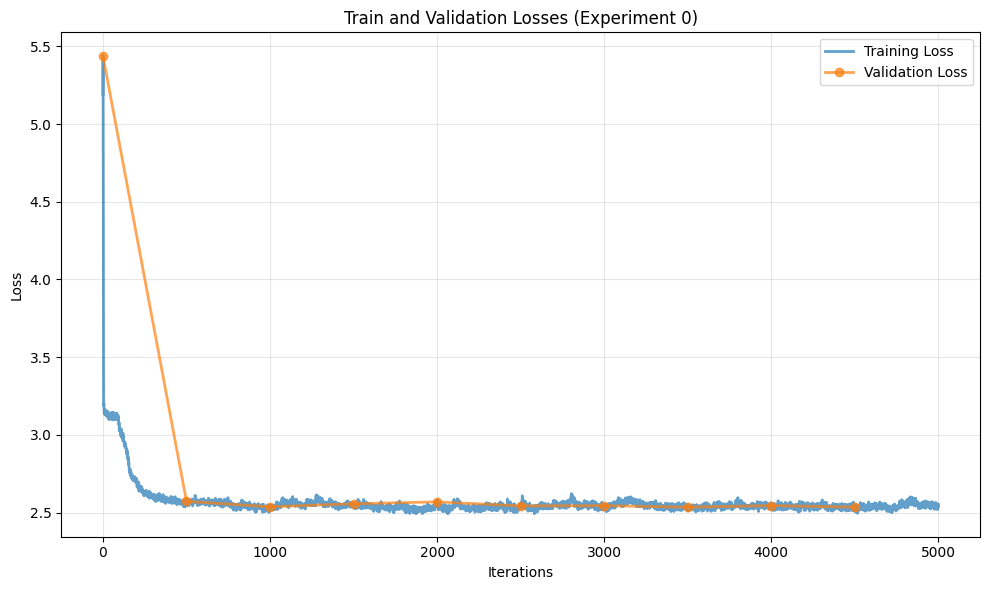

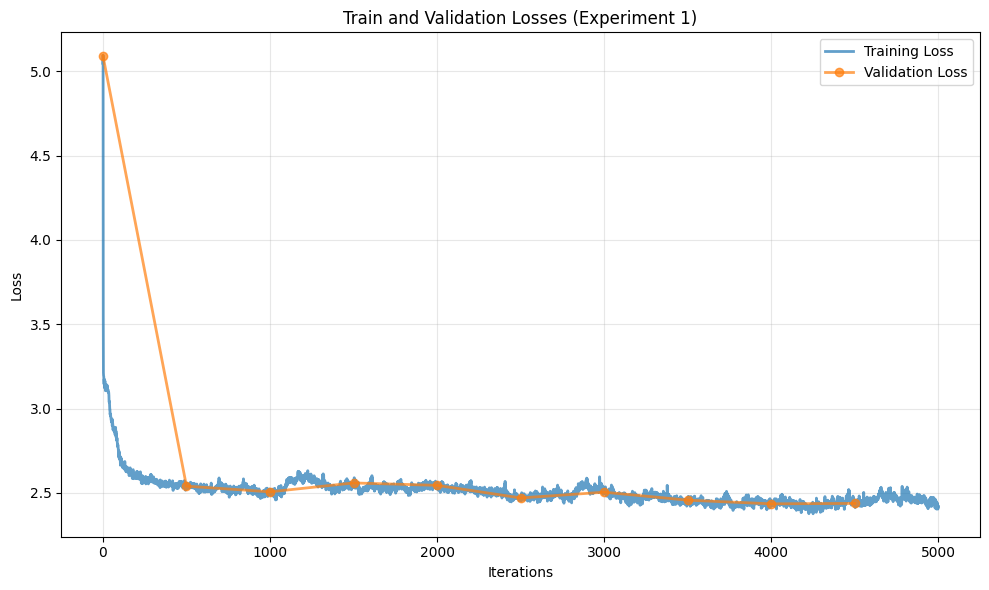

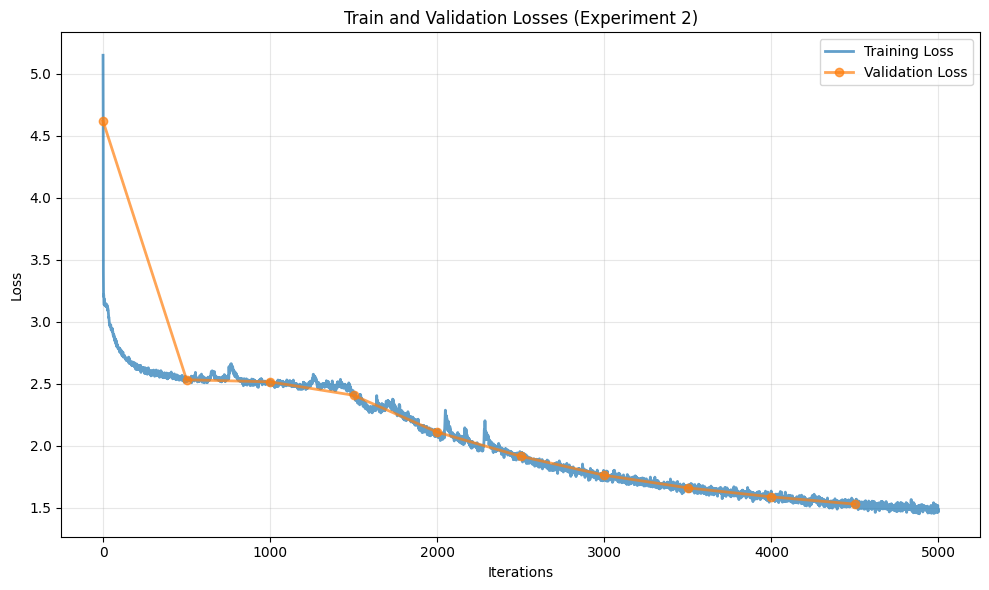

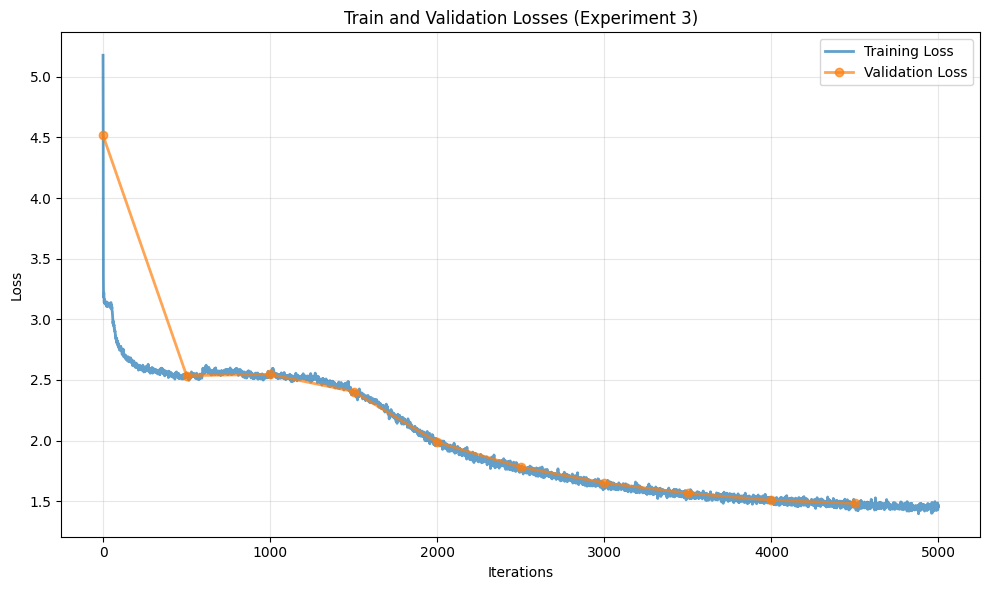

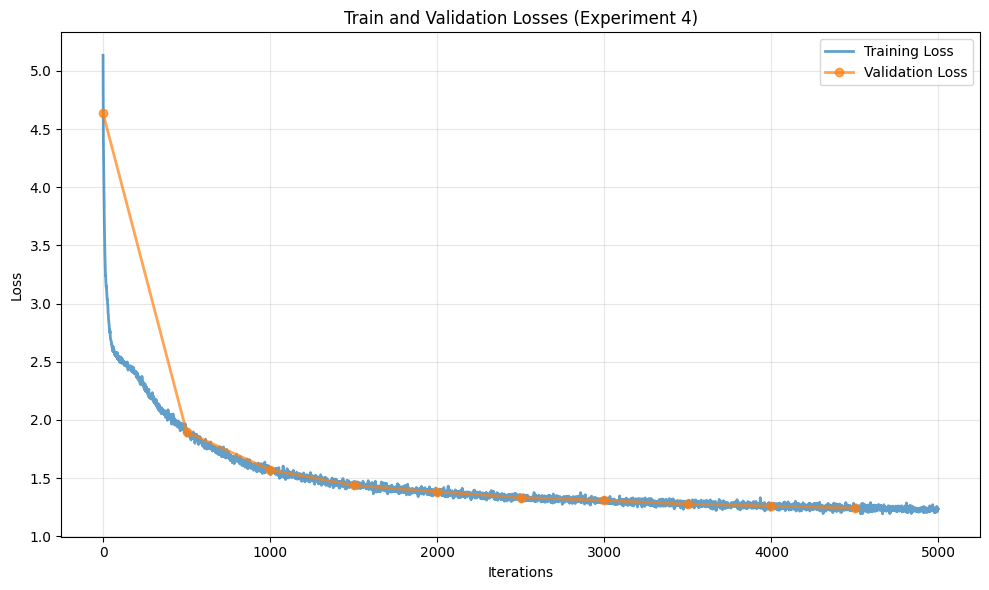

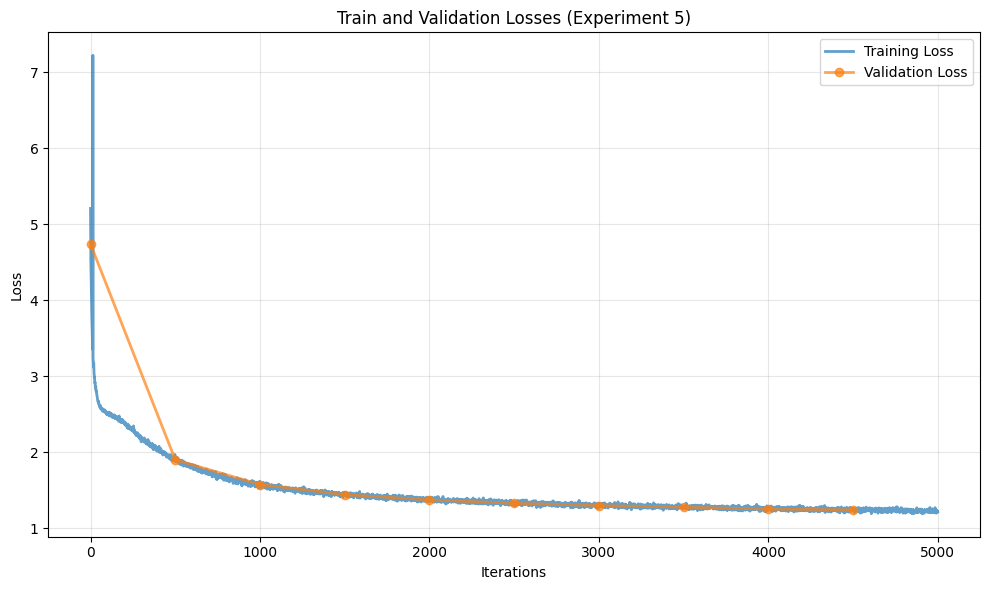

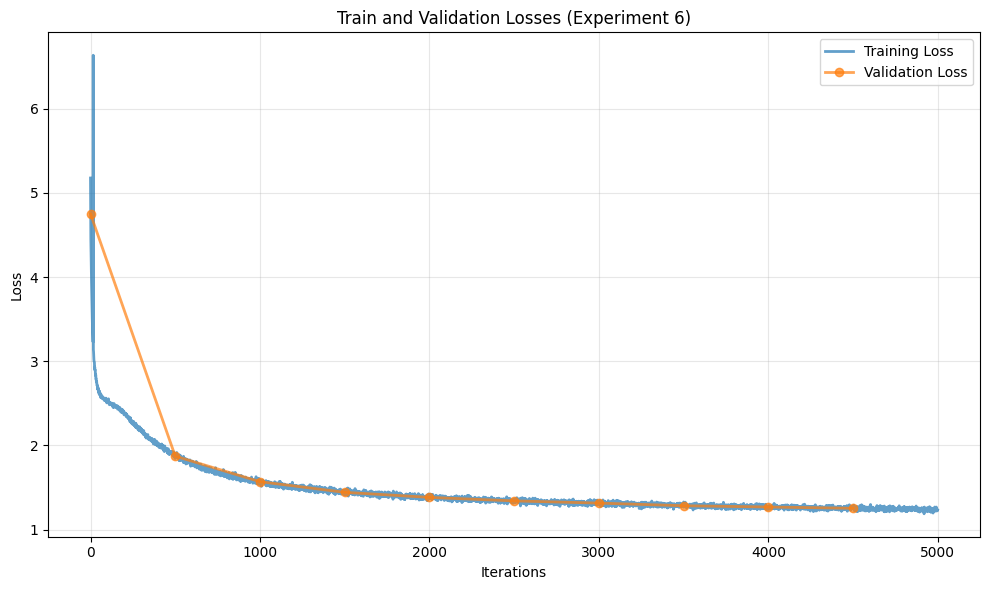

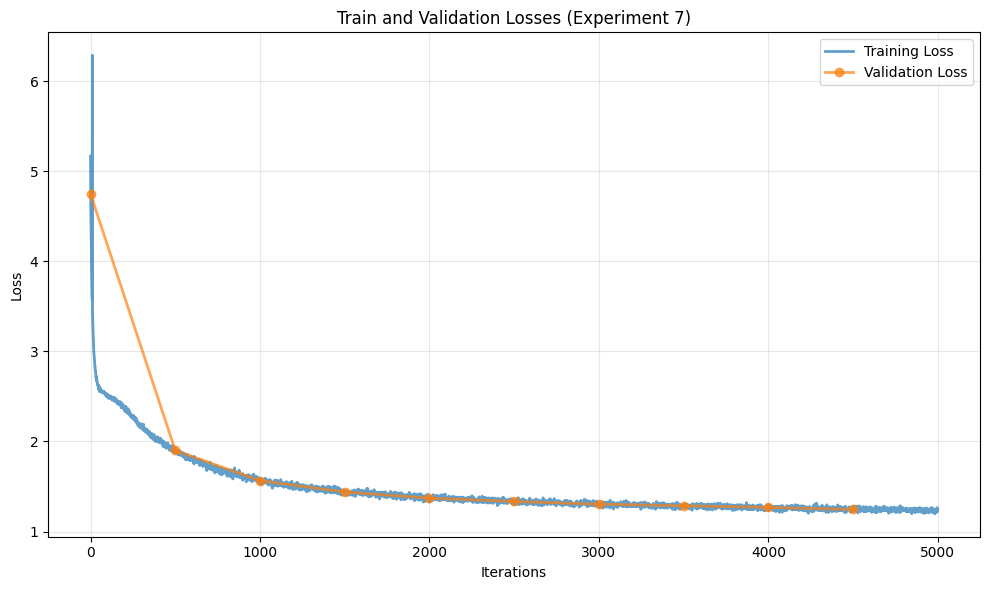

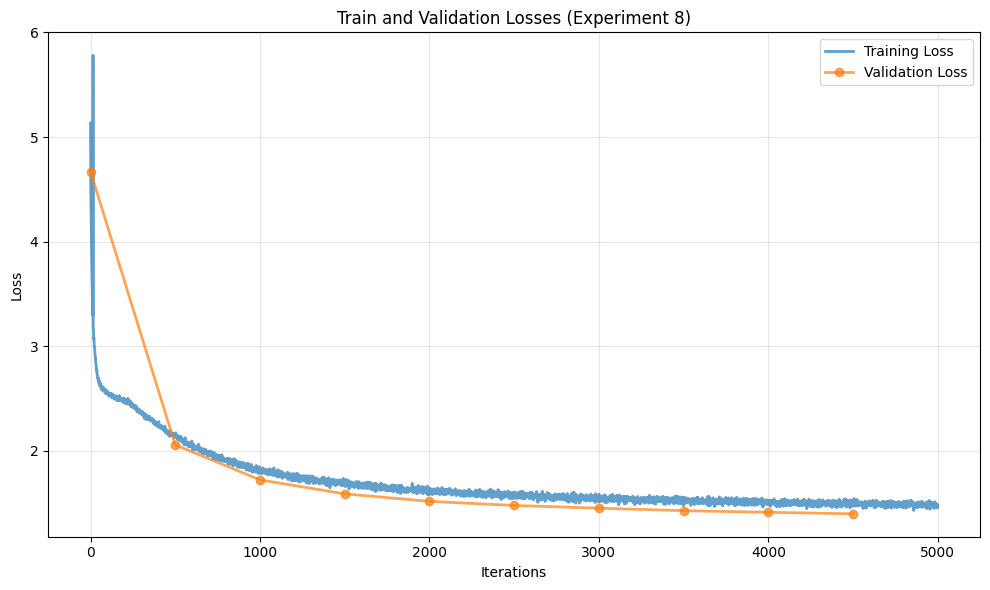

In [24]:
import matplotlib.pyplot as plt
import itertools
import json
import os

def plot_losses(results, experiment_id):
    experiment_result = next((result for result in results if result['experiment_id'] == experiment_id), None)
    if not experiment_result:
        print(f"No result found for experiment ID {experiment_id}")
        return

    train_losses = experiment_result['result']['train_losses']
    val_losses = experiment_result['result']['val_losses']

    val_iters = list(range(0, len(train_losses), len(train_losses) // len(val_losses)))
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss", alpha=0.7, linewidth=2)
    plt.plot(val_iters, val_losses, label="Validation Loss", alpha=0.7, linewidth=2, marker='o')

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Train and Validation Losses (Experiment {experiment_id})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Load results from the saved JSON file
results_file = os.path.join(out_dir, 'experiment_results.json')
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        results = json.load(f)
else:
    results = []

# Specify the experiment ID to plot
plot_losses(results, 0)
plot_losses(results, 1)
plot_losses(results, 2)
plot_losses(results, 3)
plot_losses(results, 4)
plot_losses(results, 5)
plot_losses(results, 6)
plot_losses(results, 7)

results_file1 = os.path.join(out_dir, 'experiment_results1.json')
if os.path.exists(results_file1):
    with open(results_file1, 'r') as f:
        results1 = json.load(f)
else:
    results1 = []

plot_losses(results1, 8)